# A2C с бинарным вектором

In [1]:
from snake_v0_ai import Game, RenderMode

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, ReLU
from tensorflow.keras.optimizers.legacy import Adam

import numpy as np
import matplotlib.pyplot as plt

import random
import pickle
from collections import deque
from functools import partial
from IPython.display import clear_output
import tracemalloc as tm
from tensorflow.python.framework.ops import disable_eager_execution

pygame 2.5.2 (SDL 2.28.2, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


2023-10-13 20:03:01.775916: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-13 20:03:02.012676: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-13 20:03:02.012738: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-13 20:03:02.012789: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-13 20:03:02.026770: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-13 20:03:04.380184: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
disable_eager_execution()

In [3]:
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 1e-2
GAMMA = 0.9

GAME_FIELD_SIZE = 10

STATE_VECTOR_SIZE = GAME_FIELD_SIZE**2
WEIGHTS_DIRECTORY = "weights/actor_critic/a2c/"

In [4]:
class Agent:

    def __init__(self, lr, gamma, input_shape, n_actions):
        self.lr = lr
        self.gamma = gamma
        self.input_shape = input_shape
        
        self.n_games = 0
        self.n_actions = n_actions
        self.action_space = list(range(n_actions))

        self.actor, self.critic, self.policy = self.__init_models()
        self.action = None
        self.stats = {
            "scores": [],
            "rewards": [],
        }

    def __init_models(self):
        inp = Input(self.input_shape)
        delta = Input((self.n_actions,))
        x = Dense(1024, activation="relu")(inp)
        x = Dense(512, activation="relu")(x)
        p = Dense(self.n_actions, activation="softmax")(x)
        values = Dense(self.n_actions)(x)
        
        def custom_loss(y_true, y_pred):            
            out = tf.clip_by_value(y_pred, 1e-8, 1-1e-8)
            log_lik = y_true* tf.math.log(out)

            return tf.math.reduce_sum(-log_lik * delta)

        actor = Model((inp, delta), (p,))
        actor.compile(Adam(self.lr), loss=custom_loss)

        critic = Model((inp,), (values,))
        critic.compile(Adam(self.lr), loss="mse")

        policy = Model((inp,), (p,))

        return actor, critic, policy

    def generate_action(self, x):
        x = self.policy.predict(x[None, ...])
        p = x[0]
        # p = p / np.sum(p)
        action = np.random.choice(self.action_space, p=p)
        return action - 1

    def learn(self, state, action, reward, new_state, done):
        state = state[None, ...]
        new_state = new_state[None, ...]

        critic_v = self.critic.predict(state)
        critic_v_new = self.critic.predict(new_state)

        target = reward + self.gamma * critic_v_new * int(not done)
        delta = target - critic_v
        
        actions = np.zeros((1, self.n_actions))
        actions[0, action] = 1

        self.actor.fit((state, delta), actions, verbose=0)
        self.critic.fit(state, target, verbose=0)

    def plot_statistics(self):
        fig, (lax, rax) = plt.subplots(1, 2, figsize=(15, 5))
        lax.plot(self.stats["scores"])
        lax.set_title(f"Scores")
        rax.plot(self.stats["rewards"])
        rax.set_title(f"Rewards")
        fig.suptitle(f"{self.n_games} games")
        plt.show()

    def backup(self):
        self.actor.save_weights(f"{WEIGHTS_DIRECTORY}/actor{self.n_games}.keras")
        self.critic.save_weights(f"{WEIGHTS_DIRECTORY}/critic{self.n_games}.keras")
        self.policy.save_weights(f"{WEIGHTS_DIRECTORY}/policy{self.n_games}.keras")

In [5]:
env = Game(GAME_FIELD_SIZE, mode=RenderMode.BINARY_VECTOR, verbose=True)

In [11]:
agent = Agent(1e-5, 0.99, 11, 3)

In [8]:
def start_epoch(agent: Agent):
    steps_without_apple = 0
    done = False
    old_state, info = env.reset()
    # old_state = (old_state / 255).reshape((-1, ))
    total_reward = 0
    
    while not done:
        steps_without_apple += 1
        action = agent.generate_action(old_state)
        new_state, reward, done, _ = env.step(action)
        # new_state = (new_state / 255).reshape((-1, ))

        if reward == 10:
            steps_without_apple = 0

        elif abs(reward) < 1:
            reward *= 10

        if steps_without_apple > 100:
            reward = -10
            done = True
        
        agent.learn(old_state, action, reward, new_state, done)
        old_state = new_state

        total_reward += reward

    return env.score - 3, total_reward

In [9]:
def train(agent: Agent, epochs: int, display_frequency: int = 100, verbose: bool = True):
    
    for i in range(epochs):
        score, reward = start_epoch(agent)
        agent.n_games += 1
        agent.stats["scores"].append(score)
        agent.stats["rewards"].append(reward)
        clear_output(True)
        print(f"Epoch {i + 1}", end="\r")
        agent.plot_statistics()

        if (i + 1) % display_frequency == 0:
            agent.backup()

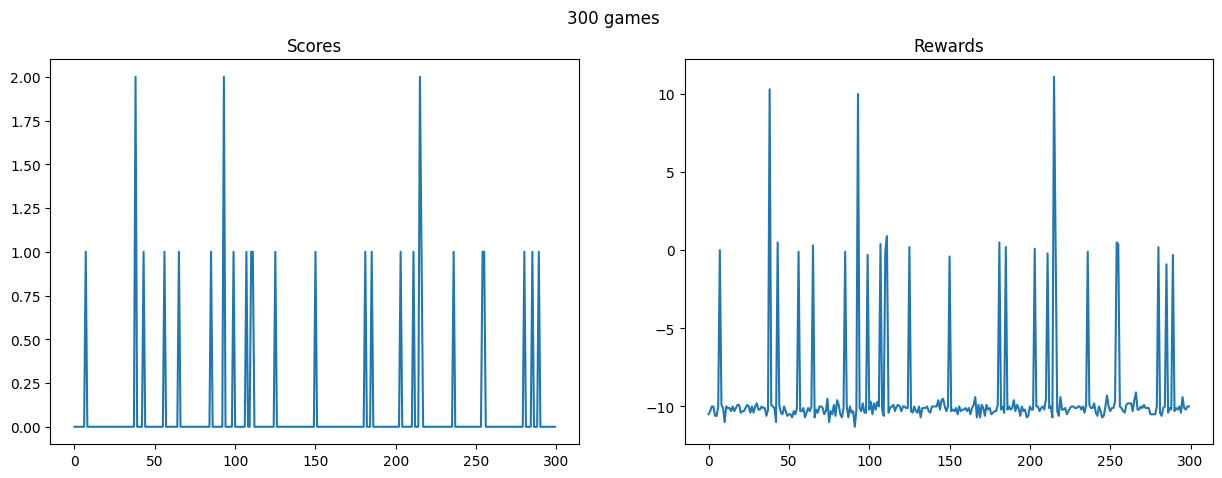

: 

In [12]:
train(agent, 300, 50)

### Сложно сказать что именно препятствовало схождению этой сетки. Она сама по себе довольно сложная, так ещё и требует тщательного подбора гиперпараметров. Я пытался, но подобрать их так и не получилось.